In [1]:
from scipy.signal import cheby1, cheby2, ellip, freqz, lfilter
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import scipy.io.wavfile as wf
from collections import deque
from scipy.optimize import root
from time import time_ns, sleep

# 1 Offline system

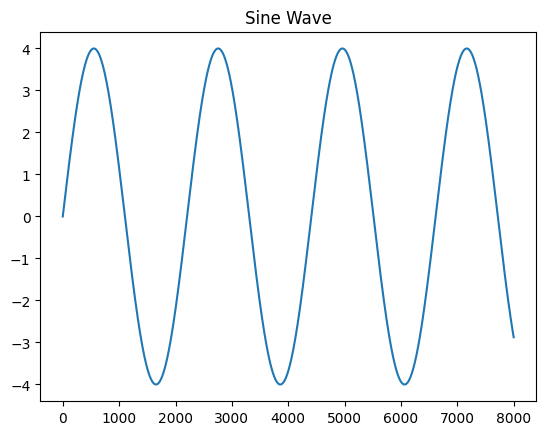

In [2]:
def create_sine_wave(f, A, fs, N):
    t = np.linspace(0,N/fs, N, endpoint=False)
    out = A * np.sin(2 * np.pi * f * t)
    return out, t

# Test de la fonction
fs = 44100  # Fréquence d'échantillonnage
N = 8000    # Nombre d'échantillons
freq = 20   # Fréquence de l'onde
amplitude = 4  # Amplitude de crête
sine_wave, t = create_sine_wave(freq, amplitude, fs, N)
plt.plot(sine_wave)
plt.title("Sine Wave")
plt.show()

# 1.1 Data generation and dataset

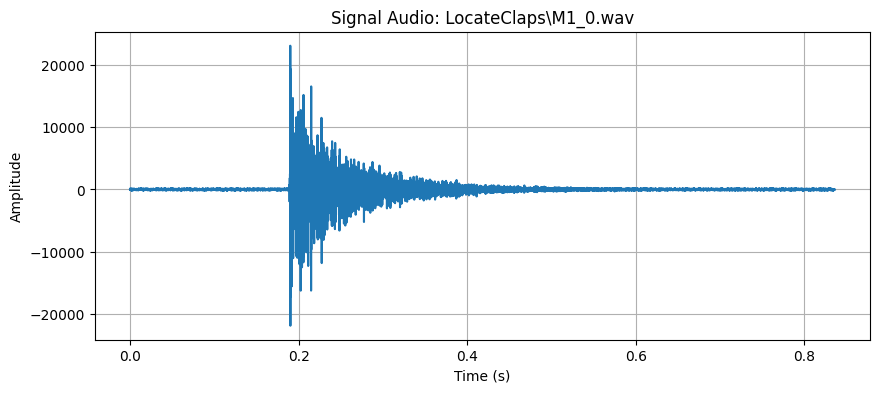

In [3]:
import scipy.io.wavfile as wf
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# Fonction pour lire un fichier WAV
def read_wavefile(path):
    rate, data = wf.read(path)
    return rate, data

# Récupérer les fichiers WAV
LocateClaps = "LocateClaps"
files = glob(f"{LocateClaps}/*.wav")

# Tester la fonction sur le premier fichier
if files:
    file_path = files[0]
    rate, data = read_wavefile(file_path)
    
    # Calculer le temps en secondes
    time = np.linspace(0, len(data) / rate, num=len(data))
    
    # Tracer le signal
    plt.figure(figsize=(10, 4))
    plt.plot(time, data)
    plt.title(f"Signal Audio: {file_path.split('/')[-1]}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()
else:
    print("Aucun fichier .wav trouvé dans le dossier LocateClaps.")



# 1.2 Buffering


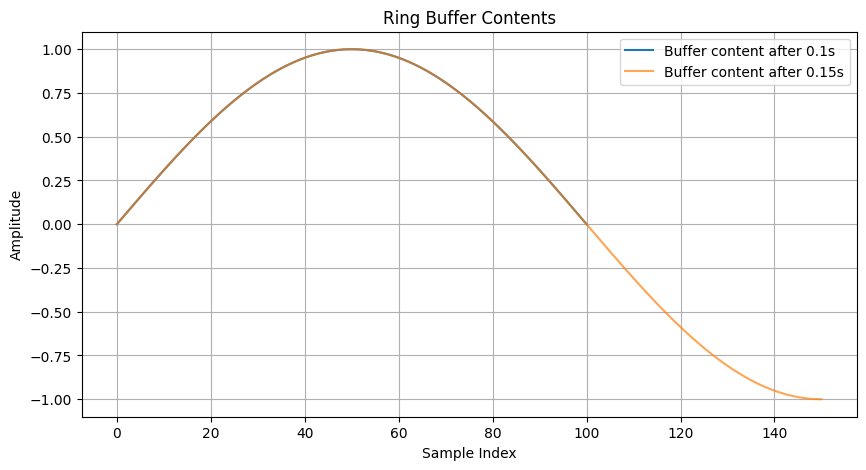

"A VERIFIER, JE NE SAIS PAS SI LE GRAPHIQUE EST BIEN CE QU'ON VEUT"

In [4]:
from collections import deque

def create_ringbuffer(maxlen):
    return deque(maxlen=maxlen)

# Parameters
f = 5        # Frequency in Hz
A = 1        # Amplitude
fs = 1000    # Sampling rate in Hz
N = 1000     # Number of samples
maxlen = 750 # Maximum buffer size

# Generate the sine wave
sine_wave, t = create_sine_wave(f, A, fs, N)

# Initialize the ring buffer
ring_buffer = create_ringbuffer(maxlen=maxlen)

# Simulate storing samples in the buffer
buffer_01s = []
buffer_015s = []

for i, sample in enumerate(sine_wave):
    ring_buffer.append(sample)
    # Store buffer content after 0.1s and 0.15s
    if i == int(0.1 * fs):
        buffer_01s = list(ring_buffer)
    elif i == int(0.15 * fs):
        buffer_015s = list(ring_buffer)

# Plot the buffer contents
plt.figure(figsize=(10, 5))
plt.plot(buffer_01s, label="Buffer content after 0.1s")
plt.plot(buffer_015s, label="Buffer content after 0.15s", alpha=0.7)
plt.title("Ring Buffer Contents")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

"""A VERIFIER, JE NE SAIS PAS SI LE GRAPHIQUE EST BIEN CE QU'ON VEUT"""

# 1.3 Pre-processing

## 1.3.1 Normalisation

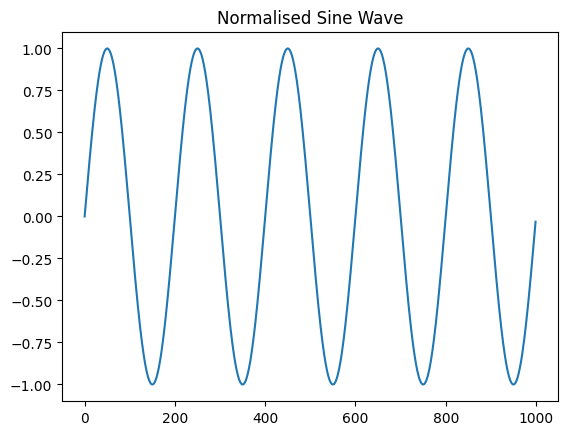

In [5]:
def normalise(s):
    return s / np.max(np.abs(s))

# Test de la fonction
normalised_signal = normalise(sine_wave)
plt.plot(normalised_signal)
plt.title("Normalised Sine Wave")
plt.show()

## 1.3.2 Downsampling

### 1 - spectral analysis via spectrogram

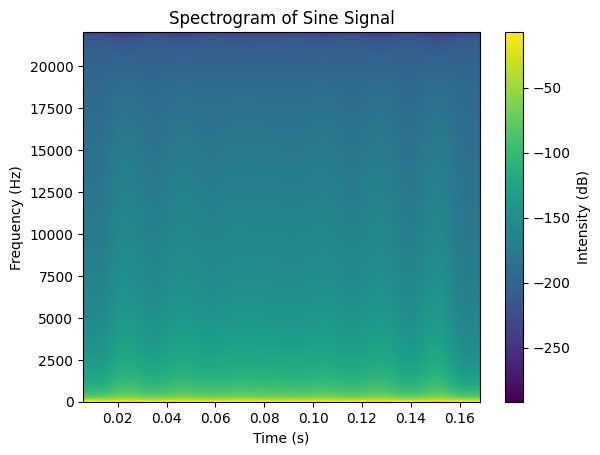

In [6]:
# Test de la fonction
fs = 44100  # Fréquence d'échantillonnage
N = 8000    # Nombre d'échantillons
freq = 20   # Fréquence de l'onde
amplitude = 4  # Amplitude de crête
sine_wave, t = create_sine_wave(freq, amplitude, fs, N)
plt.specgram(sine_wave, Fs=fs, NFFT=1024, noverlap=512, cmap='viridis')
plt.title("Spectrogram of Sine Signal")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Intensity (dB)")
plt.show()

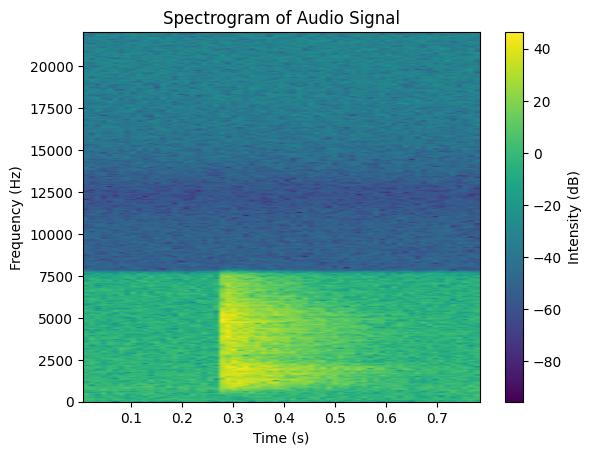

In [7]:
Fs, signal = wf.read("LocateClaps/M1_30.wav")
plt.specgram(signal, Fs=Fs, NFFT=1024, noverlap=512, cmap='viridis')
plt.title("Spectrogram of Audio Signal")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Intensity (dB)")
plt.show()

### 2 - Anti-aliasing filter synthesis

In [34]:
from scipy.signal import cheby1, ellip

def create_cheby1_filter(wp, ws, gpass, gstop, fs):
    nyquist = fs / 2
    wp_norm = wp / nyquist
    ws_norm = ws / nyquist

    # Vérification des fréquences
    if not (0 < wp_norm < 1):
        raise ValueError("La fréquence de bande passante (wp) doit être comprise entre 0 et fs/2.")
    if not (0 < ws_norm < 1):
        raise ValueError("La fréquence de bande d'arrêt (ws) doit être comprise entre 0 et fs/2.")

    # Conception du filtre Chebyshev Type I
    b, a = cheby1(N=4, rp=gpass, Wn=wp_norm, btype='low', output='ba')
    return b, a


def create_cauer_filter(wp, ws, gpass, gstop, fs):
    nyquist = fs / 2
    wp_norm = wp / nyquist
    ws_norm = ws / nyquist

    # Vérification des fréquences
    if not (0 < wp_norm < 1):
        raise ValueError("La fréquence de bande passante (wp) doit être dans (0, fs/2)")
    if not (0 < ws_norm < 1):
        raise ValueError("La fréquence de bande d'arrêt (ws) doit être dans (0, fs/2)")

    # Conception du filtre
    b, a = ellip(N=4, rp=gpass, rs=gstop, Wn=wp_norm, btype='low')
    return b, a


AFFICHAGE DES FILTRES

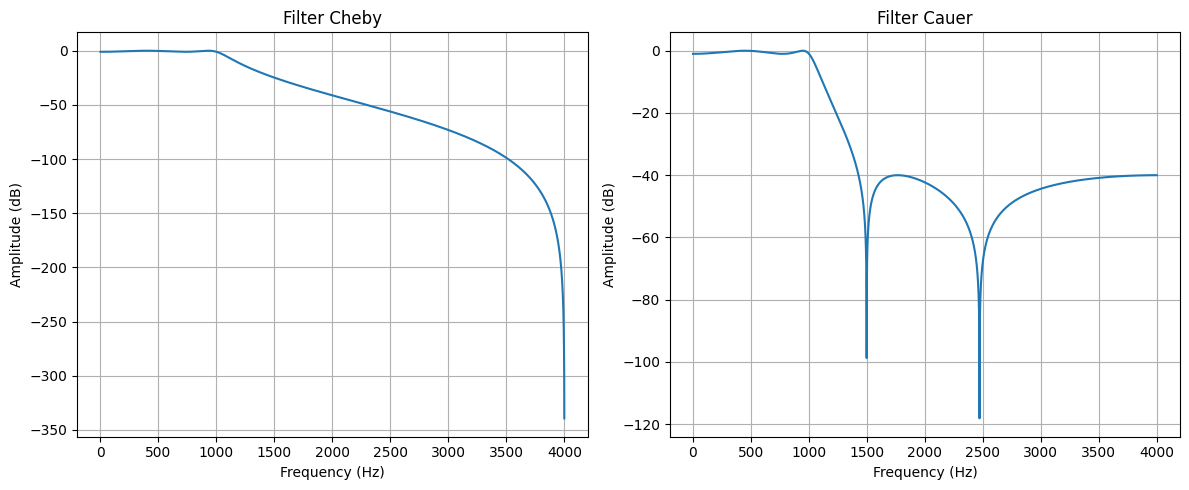

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

def plot_filter_responses(b_cheby, a_cheby, b_cauer, a_cauer, fs):
    # Réponse en fréquence pour Chebyshev
    w_cheby, h_cheby = freqz(b_cheby, a_cheby, worN=8000, fs=fs)
    # Réponse en fréquence pour Cauer
    w_cauer, h_cauer = freqz(b_cauer, a_cauer, worN=8000, fs=fs)

    # Tracer les deux réponses côte à côte
    plt.figure(figsize=(12, 5))
    
    # Filtre Chebyshev
    plt.subplot(1, 2, 1)
    plt.plot(w_cheby, 20 * np.log10(abs(h_cheby)))
    plt.title("Filter Cheby")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude (dB)")
    plt.grid()
    
    # Filtre Cauer
    plt.subplot(1, 2, 2)
    plt.plot(w_cauer, 20 * np.log10(abs(h_cauer)))
    plt.title("Filter Cauer")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude (dB)")
    plt.grid()
    
    plt.tight_layout()
    plt.show()

# Affichage des filtres
plot_filter_responses(b_cheby, a_cheby, b_cauer, a_cauer, fs)

NameError: name 'signal_composite' is not defined

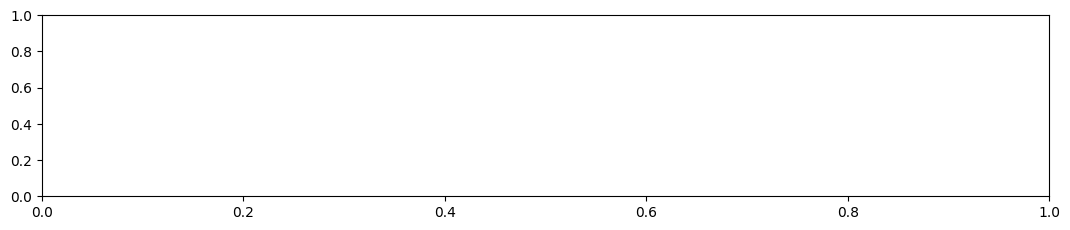

In [ ]:
# Définition des paramètres
fs = 20000  # Fréquence d'échantillonnage (Hz)
t = np.linspace(0, 0.01, int(fs * 0.01), endpoint=False)  # Axe temporel (10 ms)

# Signaux composés
sinus1 = 100 * np.sin(2 * np.pi * 8500 * t)  # Sinusoïde 1 : amplitude 100V, fréquence 8500Hz
sinus2 = 20 * np.sin(2 * np.pi * 7500 * t)   # Sinusoïde 2 : amplitude 20V, fréquence 7500Hz
signal_composite = sinus1 + sinus2  # Signal composite

# Paramètres des filtres
wp = 8000  # Bande passante (Hz)
ws = 8500  # Bande d'arrêt (Hz)
gpass = 1  # Ondulation dans la bande passante (dB)
gstop = 40  # Atténuation dans la bande d'arrêt (dB)

# Filtre Chebyshev
nyquist = fs / 2
wp_norm = wp / nyquist
ws_norm = ws / nyquist
b_cheby, a_cheby = cheby1(N=4, rp=gpass, Wn=wp_norm, btype='low', output='ba')

# Filtre Cauer (Elliptique)
b_cauer, a_cauer = ellip(N=4, rp=gpass, rs=gstop, Wn=wp_norm, btype='low', output='ba')

# Application des filtres
signal_cheby = lfilter(b_cheby, a_cheby, signal_composite)
signal_cauer = lfilter(b_cauer, a_cauer, signal_composite)

# Affichage des résultats
plt.figure(figsize=(12, 8))

# Plotting
plt.figure(figsize=(13, 8))

# Signal original
plt.subplot(3, 1, 1)
plt.plot(t, signal_composite, label="Signal original")
plt.title("Signal original (composé de deux sinusoïdes)")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude (V)")
plt.grid()
plt.legend()

# Signal filtré avec Chebyshev
plt.subplot(3, 1, 2)
plt.plot(t, signal_cheby, label="Signal filtré (Chebyshev)", color="orange")
plt.title("Signal après filtrage Chebyshev")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude (V)")
plt.grid()
plt.legend()

# Signal filtré avec Cauer
plt.subplot(3, 1, 3)
plt.plot(t, signal_cauer, label="Signal filtré (Cauer)", color="green")
plt.title("Signal après filtrage Cauer")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude (V)")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

### 3 - Decimation

In [10]:
def downsampling(signal, fs, target_fs, filter_type='cheby1'):
    """
    Downsamples a signal to the target sampling frequency using an anti-aliasing filter.
    
    Args:
        signal (np.array): Input signal to be downsampled.
        fs (float): Original sampling frequency (Hz).
        target_fs (float): Target sampling frequency (Hz).
        filter_type (str): Type of anti-aliasing filter ('cheby1', 'cheby2', 'cauer').

    Returns:
        np.array: Downsampled signal.
    """
    
    if target_fs >= fs:
        raise ValueError("Target sampling frequency must be less than original frequency.")

    # Calculate downsampling factor
    downsampling_factor = int(fs / target_fs)
    if fs % target_fs != 0:
        raise ValueError("The downsampling factor must be an integer.")

    # Design the anti-aliasing filter
    nyquist = fs / 2
    cutoff = target_fs / 2 / nyquist  # Normalized cutoff frequency

    if filter_type == 'cheby1':
        b, a = cheby1(4, 1, cutoff, btype='low', analog=False)
    elif filter_type == 'cheby2':
        b, a = cheby2(4, 40, cutoff, btype='low', analog=False)
    elif filter_type == 'cauer':
        b, a = ellip(4, 1, 40, cutoff, btype='low', analog=False)
    else:
        raise ValueError("Invalid filter_type. Choose 'cheby1', 'cheby2', or 'cauer'.")

    # Apply the anti-aliasing filter
    filtered_signal = lfilter(b, a, signal)

    # Perform downsampling
    downsampled_signal = filtered_signal[::downsampling_factor]

    return downsampled_signal

Test

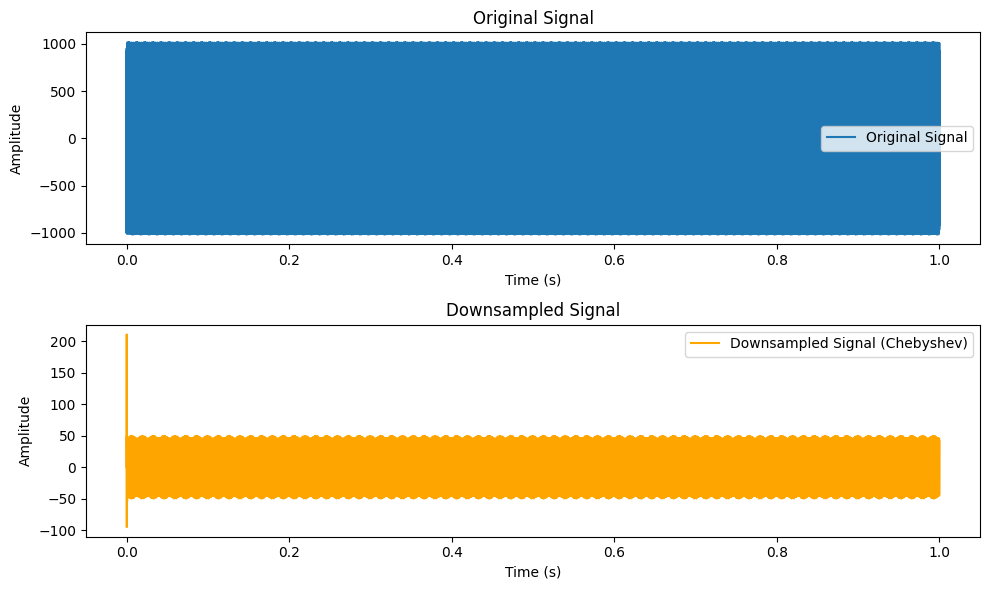

In [11]:
# Example: Downsampling the test signal from 44100 Hz to 11025 Hz
target_fs = 11025
downsampled_signal = downsampling(test_signal, fs, target_fs, filter_type='cheby1')

# Plotting the result
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, test_signal, label="Original Signal")
plt.title("Original Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(2, 1, 2)
downsampled_time = np.linspace(0, len(downsampled_signal) / target_fs, len(downsampled_signal), endpoint=False)
plt.plot(downsampled_time, downsampled_signal, label="Downsampled Signal (Chebyshev)", color='orange')
plt.title("Downsampled Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()

Length of original signal: 36865
Length of decimated signal: 9217
Length of time vector for decimated signal: 9217
Decimation factor: 4.0


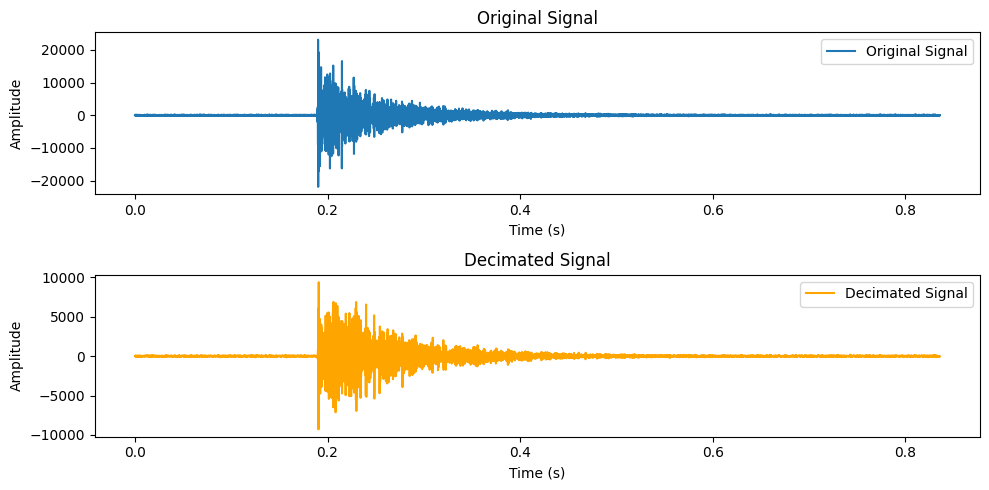

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cheby1, lfilter
from scipy.io import wavfile as wf

# Read Original Signal
fs, signal = wf.read("LocateClaps/M1_0.wav")

# Create Time Vector for Original Signal
t = np.linspace(0, len(signal) / fs, len(signal), endpoint=False)

# Anti-aliasing Filter
M = 4  # Decimation factor
nyquist = fs / 2
cutoff = 1 / (2 * M)  # Normalized cutoff frequency
b, a = cheby1(4, 1, cutoff, btype='low')
filtered_signal = lfilter(b, a, signal)

# Decimation
decimated_signal = filtered_signal[::M]
fs_decimated = fs // M  # New sampling frequency

# Create Time Vector for Decimated Signal
t_decimated = np.linspace(0, len(decimated_signal) / fs_decimated, len(decimated_signal), endpoint=False)

# Verification
print(f"Length of original signal: {len(signal)}")
print(f"Length of decimated signal: {len(decimated_signal)}")
print(f"Length of time vector for decimated signal: {len(t_decimated)}")
print(f"Decimation factor: {fs / fs_decimated}")

# Plotting
plt.figure(figsize=(10, 5))

# Original Signal
plt.subplot(2, 1, 1)
plt.plot(t, signal, label="Original Signal")
plt.title("Original Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# Decimated Signal
plt.subplot(2, 1, 2)
plt.plot(t_decimated, decimated_signal, label="Decimated Signal", color='orange')
plt.title("Decimated Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()


Length of original signal: 36865
Length of decimated signal: 9217
Length of time vector for decimated signal: 9217
Decimation factor: 4.0


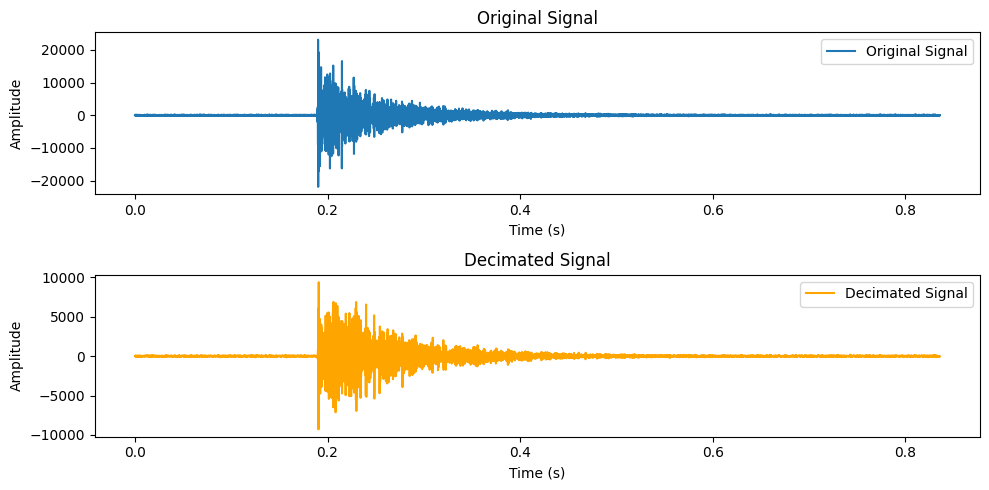

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cheby1, lfilter
from scipy.io import wavfile as wf

# Read Original Signal
fs, signal = wf.read("LocateClaps/M1_0.wav")

# Create Time Vector for Original Signal
t = np.linspace(0, len(signal) / fs, len(signal), endpoint=False)

# Anti-aliasing Filter
M = 4  # Decimation factor
nyquist = fs / 2
cutoff = 1 / (2 * M)  # Normalized cutoff frequency
b, a = cheby1(4, 1, cutoff, btype='low')
filtered_signal = lfilter(b, a, signal)

# Decimation
decimated_signal = filtered_signal[::M]
fs_decimated = fs // M  # New sampling frequency

# Create Time Vector for Decimated Signal
t_decimated = np.linspace(0, len(decimated_signal) / fs_decimated, len(decimated_signal), endpoint=False)

# Verification
print(f"Length of original signal: {len(signal)}")
print(f"Length of decimated signal: {len(decimated_signal)}")
print(f"Length of time vector for decimated signal: {len(t_decimated)}")
print(f"Decimation factor: {fs / fs_decimated}")

# Plotting
plt.figure(figsize=(10, 5))

# Original Signal
plt.subplot(2, 1, 1)
plt.plot(t, signal, label="Original Signal")
plt.title("Original Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# Decimated Signal
plt.subplot(2, 1, 2)
plt.plot(t_decimated, decimated_signal, label="Decimated Signal", color='orange')
plt.title("Decimated Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()


# 1.4 Cross-correlation

In [14]:
import scipy.signal as sc
import numpy as np

def fftxcorr(signal1, signal2):
    """
    Compute the cross-correlation between two signals using FFT.
    
    Args:
        signal1 (np.array): First input signal.
        signal2 (np.array): Second input signal.

    Returns:
        np.array: Cross-correlation result.
    """
    n = len(signal1) + len(signal2) - 1  # Length of the output
    fft1 = np.fft.fft(signal1, n=n)  # FFT of the first signal
    fft2 = np.fft.fft(signal2, n=n)  # FFT of the second signal
    cross_corr = np.fft.ifft(fft1 * np.conj(fft2)).real  # Cross-correlation
    return np.fft.fftshift(cross_corr)  # Shift zero lag to the center

Test

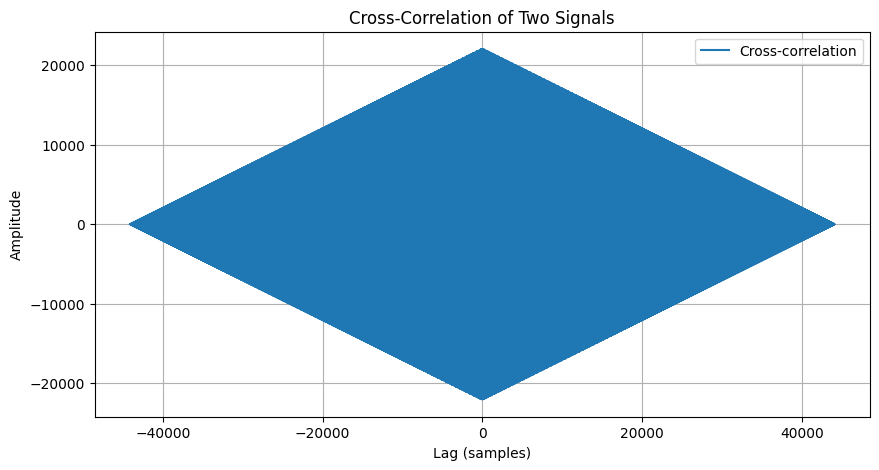

In [15]:
# Example signals
fs = 44100  # Sampling frequency
t = np.linspace(0, 1, fs, endpoint=False)  # 1 second time vector
signal1 = np.sin(2 * np.pi * 1000 * t)  # 1 kHz sine wave
signal2 = np.sin(2 * np.pi * 1000 * t + np.pi / 4)  # 1 kHz sine wave with phase shift

# Cross-correlation
cross_corr = fftxcorr(signal1, signal2)

# Plotting
lags = np.arange(-len(signal1) + 1, len(signal2))

plt.figure(figsize=(10, 5))
plt.plot(lags, cross_corr, label="Cross-correlation")
plt.title("Cross-Correlation of Two Signals")
plt.xlabel("Lag (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

# 1.5 Localisation

## 1.5.1 TDOA

In [16]:
def TDOA(cross_corr, fs):
    """
    Compute the Time Difference of Arrival (TDOA) between two signals using their cross-correlation.

    Args:
        cross_corr (np.array): Cross-correlation result.
        fs (float): Sampling frequency (Hz).

    Returns:
        float: Time difference of arrival (TDOA) in seconds.
    """
    # Find the lag corresponding to the peak in the cross-correlation
    max_index = np.argmax(cross_corr)
    center_index = len(cross_corr) // 2
    lag_samples = max_index - center_index  # Lag in samples

    # Convert lag from samples to time
    tdoa = lag_samples / fs
    return tdoa


## 1.5.2 Equation system

In [17]:
from scipy.optimize import root

# mic coordinates in meters
MICS = [{'x': 0, 'y': 0.0487}, {'x': 0.0425, 'y': -0.025}, {'x': -0.0425, 'y': -0.025}] 

def equations(p, deltas):
    v = 343
    x, y = p
    alpha = np.arctan2((MICS[1]['y'] - MICS[0]['y']), (MICS[1]['x'] - MICS[0]['x']))
    beta = np.arctan2((MICS[2]['y'] - MICS[0]['y']), (MICS[2]['x'] - MICS[0]['x']))
    
    eq1 = v*deltas[0] - (np.sqrt((MICS[1]['x'] - MICS[0]['x'])**2 + (MICS[1]['y'] - MICS[0]['y'])**2) * np.sqrt((x)**2 + (y)**2) * np.cos(alpha-np.arctan2(y, x)))
    eq2 = v*deltas[1] - (np.sqrt((MICS[2]['x'] - MICS[0]['x'])**2 + (MICS[2]['y'] - MICS[0]['y'])**2) * np.sqrt((x)**2 + (y)**2) * np.cos(beta-np.arctan2(y, x)))
    return (eq1, eq2)
    
def localize_sound(deltas):

    sol = root(equations, [0, 0], (deltas), tol=10)
    return sol.x

def source_angle(coordinates):
    """
    Calculate the angle of a sound source in a 2D plane.

    Args:
        coordinates (tuple): (x, y) coordinates of the sound source.

    Returns:
        float: Angle in degrees, measured counterclockwise from the positive x-axis.
    """
    x, y = coordinates
    angle_radians = np.arctan2(y, x)  # Angle in radians
    angle_degrees = np.degrees(angle_radians)  # Convert to degrees
    return angle_degrees

Test

In [18]:
fs, mic1_signal = wf.read(f'LocateClaps/M1_30.wav')
fs, mic2_signal = wf.read(f'LocateClaps/M2_30.wav')
fs, mic3_signal = wf.read(f'LocateClaps/M3_30.wav')

mic1_signal = normalise(mic1_signal)
mic2_signal = normalise(mic2_signal)
mic3_signal = normalise(mic3_signal)


# Cross-correlations
cross_corr12 = np.correlate(mic1_signal, mic2_signal, mode='full')
cross_corr13 = np.correlate(mic1_signal, mic3_signal, mode='full')

# Calculate TDOAs
tdoa12 = TDOA(cross_corr12, fs)
tdoa13 = TDOA(cross_corr13, fs)

# Use the localization functions
deltas = [tdoa12, tdoa13]
coordinates = localize_sound(deltas)
angle = source_angle(coordinates)

# Output results
print(f"Coordinates of the sound source: {coordinates}")
print(f"Angle of the sound source: {angle:.2f} degrees")

Coordinates of the sound source: [0.82352941 0.47489823]
Angle of the sound source: 29.97 degrees


# 1.6 System accuracy and speed

## 1.6.1

In [19]:
def accuracy(pred_angle, gt_angle, threshold):
    
    # your code here #

    return out

## 1.6.2

In [20]:
possible_angle = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
for angle in possible_angle:
    for f in files:
        if f'_{angle}.' in f:
            mic = f.split('/')[-1].split('_')[0] #if '/' does not work, use "\\" (windows notation)

Test

## 1.6.3

In [21]:
def func_example(a, b):
    return a*b

def time_delay(func, args):
    start_time = time_ns()
    out = func(*args)
    end_time = time_ns()
    print(f"{func.__name__} in {end_time - start_time} ns")
    return out

product = time_delay(func_example, [2, 10])

# call and test your previous functions here #

func_example in 0 ns


# 2 Real-time localisation

In [22]:
# ### 2.1 Research one Raspberry Pi application

# %% [markdown]
# ### 2.2 Data acquisition and processing

# %%
#### Callback 

RESPEAKER_CHANNELS = 8
BUFFERS = []

def callback(in_data, frame_count, time_info, flag):
    global BUFFERS
    data = np.frombuffer(in_data, dtype=np.int16)
    BUFFERS[0].extend(data[0::RESPEAKER_CHANNELS])
    BUFFERS[1].extend(data[2::RESPEAKER_CHANNELS])
    BUFFERS[2].extend(data[4::RESPEAKER_CHANNELS])
    return (None, pyaudio.paContinue)

#### Stream management

RATE = 44100
RESPEAKER_WIDTH = 2
CHUNK_SIZE = 2048

def init_stream():
    print("========= Stream opened =========")
    p = pyaudio.PyAudio()
    for i in range(p.get_device_count()):
        device_info = p.get_device_info_by_index(i)

        if device_info['maxInputChannels'] == 8:
            INDEX = i
            break

        if i == p.get_device_count()-1:
            # Sound card not found
            raise OSError('Invalid number of channels')

    stream = p.open(rate=RATE, channels=RESPEAKER_CHANNELS, format=p.get_format_from_width(RESPEAKER_WIDTH), input=True, input_device_index=INDEX,
                    frames_per_buffer=CHUNK_SIZE, stream_callback=callback)

    return stream



def close_stream(stream):
    print("========= Stream closed =========")
    stream.stop_stream()
    stream.close()

#### Detection and visual feedback
def detection(stream):
    global BUFFERS, pixel_ring
    
    if stream.is_active():
        print("========= Recording =========")

    while stream.is_active():
        try:
            if len(BUFFERS[0]) > CHUNK_SIZE:
                st = time_ns()
                deltas = [TDOA(fftxcorr(BUFFERS[0], BUFFERS[1])), TDOA(fftxcorr(BUFFERS[0], BUFFERS[2]))] 

                x, y = localize_sound(deltas)
                hyp = np.sqrt(x**2+y**2)
                
                ang_cos = round(np.arccos(x/hyp)*180/np.pi, 2)
                ang_sin = round(np.arcsin(y/hyp)*180/np.pi, 2)

                if ang_cos == ang_sin:
                    ang = ang_cos
                else:
                    ang = np.max([ang_cos, ang_sin])
                    if ang_cos < 0 or ang_sin < 0:
                        ang *= -1
                ang *= -1

                print((time_ns() - st)/1e9, ang)

                print(np.max(BUFFERS, axis=-1))

                if (np.max(BUFFERS, axis=-1) > 3000).any():
                    pixel_ring.wakeup(ang)
                else:
                    pixel_ring.off()

                sleep(0.5)

        except KeyboardInterrupt:
            print("========= Recording stopped =========")
            break

#### Launch detection
from pixel_ring.apa102_pixel_ring import PixelRing
from gpiozero import LED


USED_CHANNELS = 3


power = LED(5)
power.on()

pixel_ring = PixelRing(pattern='soundloc')

pixel_ring.set_brightness(10)

for i in range(USED_CHANNELS):
    BUFFERS.append(create_ringbuffer(3 * CHUNK_SIZE))
    
stream = init_stream()

while True:
    try:
        detection(stream)
        sleep(0.5)
    except KeyboardInterrupt:
        break

close_stream(stream)

power.off()




ModuleNotFoundError: No module named 'pixel_ring'